In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "/home/v-nitin.gupta/Desktop/fastai-master/courses/dl1/data/chest_xray/chest_xray/"


sz=224

In [5]:
torch.cuda.is_available()

False

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['sample', 'test', 'train', '.DS_Store', 'models', 'test1', 'valid', 'tmp']

In [8]:
os.listdir(f'{PATH}/valid/')

['NORMAL', '.DS_Store', 'PNEUMONIA']

In [9]:
files = os.listdir(f'{PATH}/valid/NORMAL')[:5]
files

['NORMAL2-IM-1436-0001.jpeg',
 'NORMAL2-IM-1440-0001.jpeg',
 'NORMAL2-IM-1430-0001.jpeg',
 'NORMAL2-IM-1427-0001.jpeg',
 '.DS_Store']

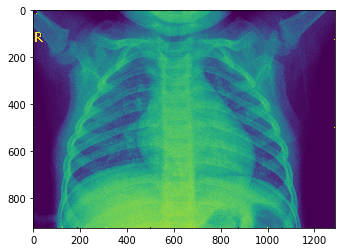

In [10]:
img = plt.imread(f'{PATH}/valid/NORMAL/{files[0]}')
plt.imshow(img);

In [11]:
img.shape

(928, 1288)

In [12]:
img[:4,:4]

array([[ 84,  85,  93,  96],
       [ 82,  82,  85,  97],
       [ 83,  79,  89, 248],
       [ 77,  79, 255,   1]], dtype=uint8)

In [13]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]



epoch      trn_loss   val_loss   accuracy                  
    0      0.194946   0.214793   0.9375    
    1      0.147124   0.299874   0.875                     


[0.29987430572509766, 0.875]

In [14]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['NORMAL', 'PNEUMONIA']

In [16]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(16, 2)

In [17]:
log_preds[:10]

array([[-1.37095, -0.29285],
       [-0.2716 , -1.43615],
       [-0.29192, -1.37369],
       [-0.17978, -1.80454],
       [-0.16331, -1.89262],
       [-0.0142 , -4.26131],
       [-0.30596, -1.33339],
       [-1.94269, -0.15469],
       [-6.03662, -0.00239],
       [-6.29387, -0.00185]], dtype=float32)

In [18]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [20]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [21]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


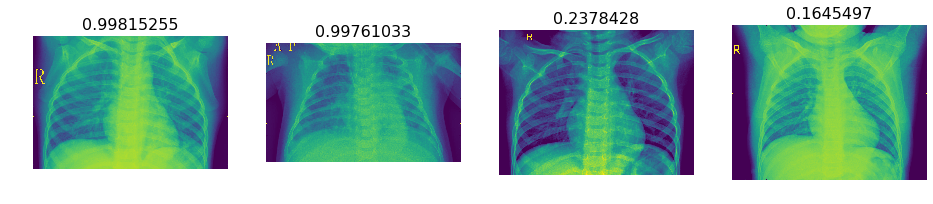

In [22]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


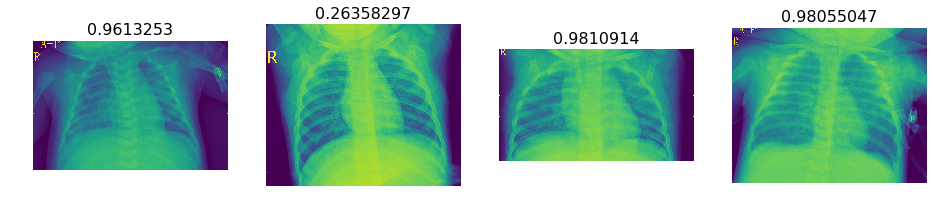

In [25]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(True), "Incorrectly classified")

In [26]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct images


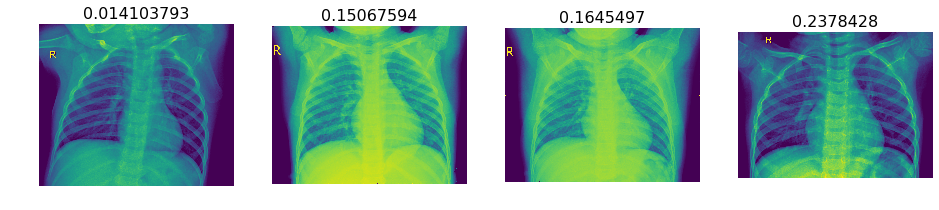

In [28]:
plot_val_with_title(most_by_correct(0, True), "Most correct images")

Most correct 


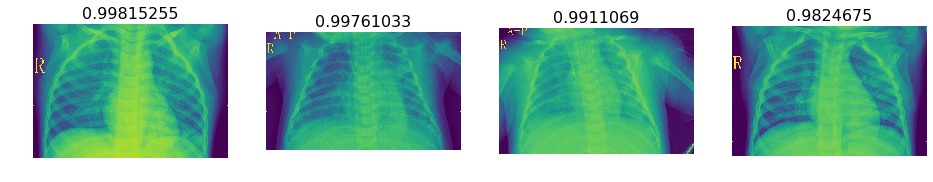

In [30]:
plot_val_with_title(most_by_correct(1, True), "Most correct ")

Most incorrect 


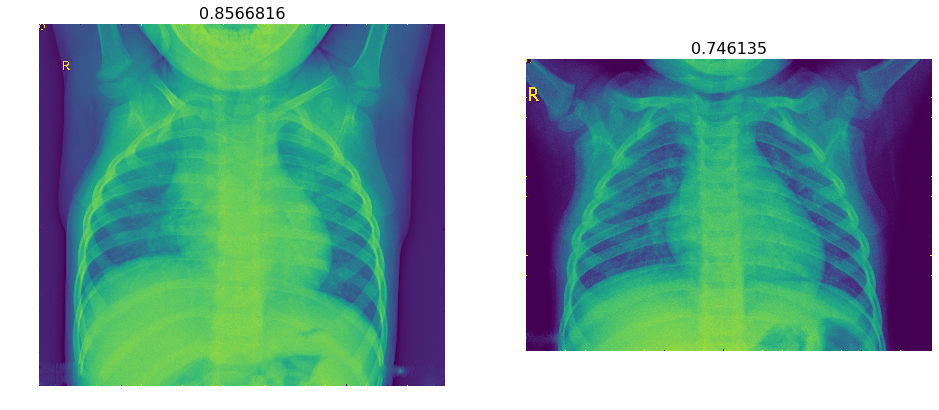

In [32]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect ")

In [34]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect ")

Most incorrect 
Not Found.


Most uncertain predictions


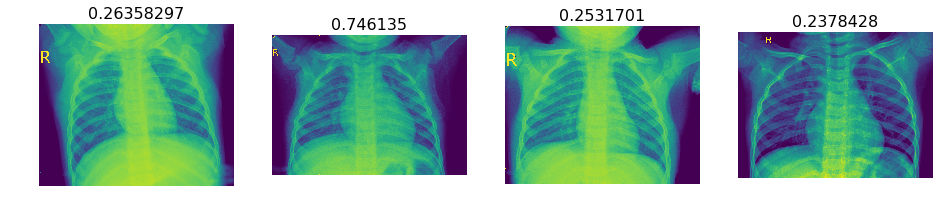

In [35]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")



# Choosing a learning rate

In [36]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [38]:
lrf=learn.lr_find()

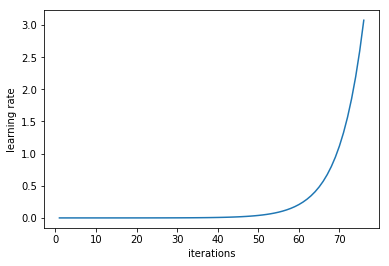

In [39]:
learn.sched.plot_lr()

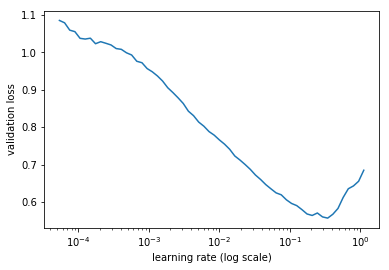

In [40]:
learn.sched.plot()

# Improving our model
Data augmentation

In [41]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [42]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [43]:
ims = np.stack([get_augs() for i in range(6)])

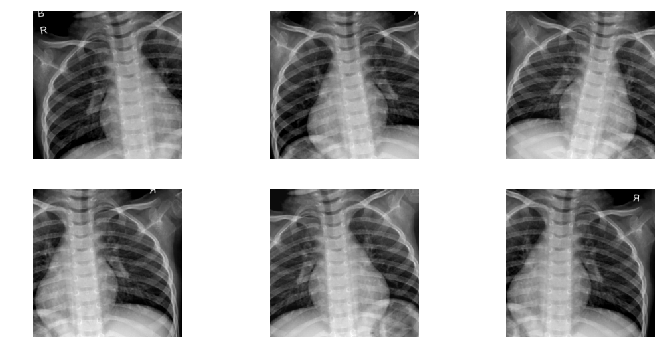

In [44]:
plots(ims, rows=2)

# Let's create a new data object that includes this augmentation in the transforms.



In [45]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [46]:
learn.fit(1e-2, 1)


epoch      trn_loss   val_loss   accuracy                  
    0      0.205648   0.232215   0.9375    


[0.23221489787101746, 0.9375]

In [47]:
learn.precompute=False

In [48]:
learn.fit(1e-2, 3, cycle_len=1)


epoch      trn_loss   val_loss   accuracy                  
    0      0.164173   0.169723   0.9375    
    1      0.15755    0.133613   1.0                       
    2      0.147086   0.13062    1.0                       


[0.1306200921535492, 1.0]

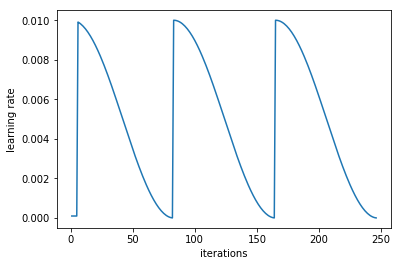

In [49]:
learn.sched.plot_lr()

In [50]:
learn.save('224_lastlayer')

In [51]:
learn.save('224_lastlayer')

In [52]:
learn.load('224_lastlayer')

In [53]:
learn.unfreeze()

In [54]:
lr=np.array([1e-4,1e-3,1e-2])

In [55]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                   
    0      0.171802   0.207409   0.875     
    1      0.116975   0.184892   0.9375                     
    2      0.098799   0.168141   0.875                      
    3      0.089988   0.187261   0.875                       
    4      0.085983   0.173515   0.875                       
    5      0.07295    0.186458   0.875                       
    6      0.064561   0.157854   0.9375                      


[0.15785416960716248, 0.9375]

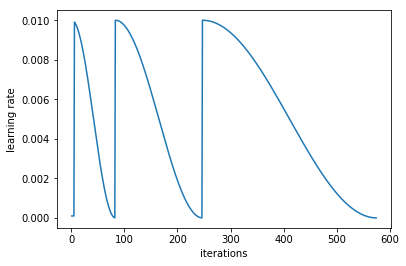

In [56]:
learn.sched.plot_lr()

In [57]:
learn.save('224_all')

In [58]:
learn.load('224_all')

In [59]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [60]:
accuracy_np(probs, y)

0.875


# Analyzing results
Confusion matrix

In [61]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[6 2]
 [0 8]]


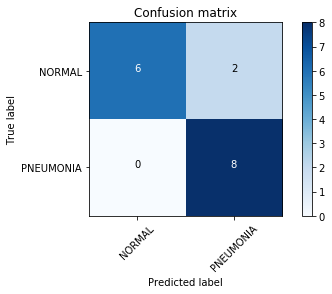

In [63]:
plot_confusion_matrix(cm, data.classes)

# Looking at pictures again

Most incorrect 


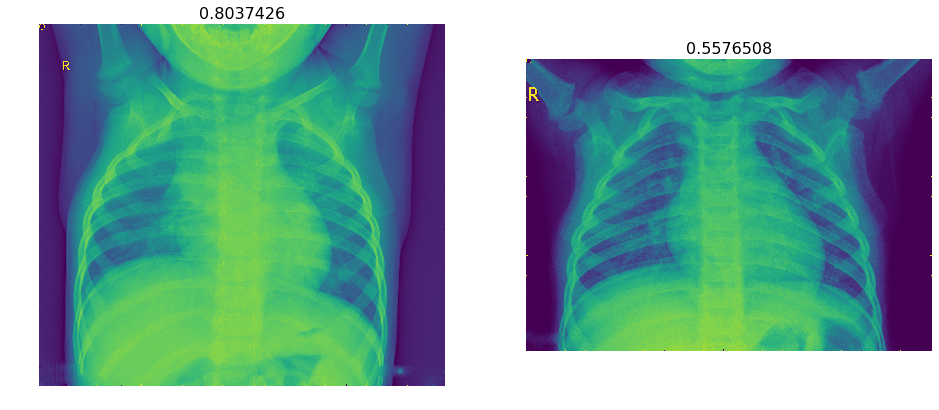

In [66]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect ")

In [67]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect ")

Most incorrect 
Not Found.
